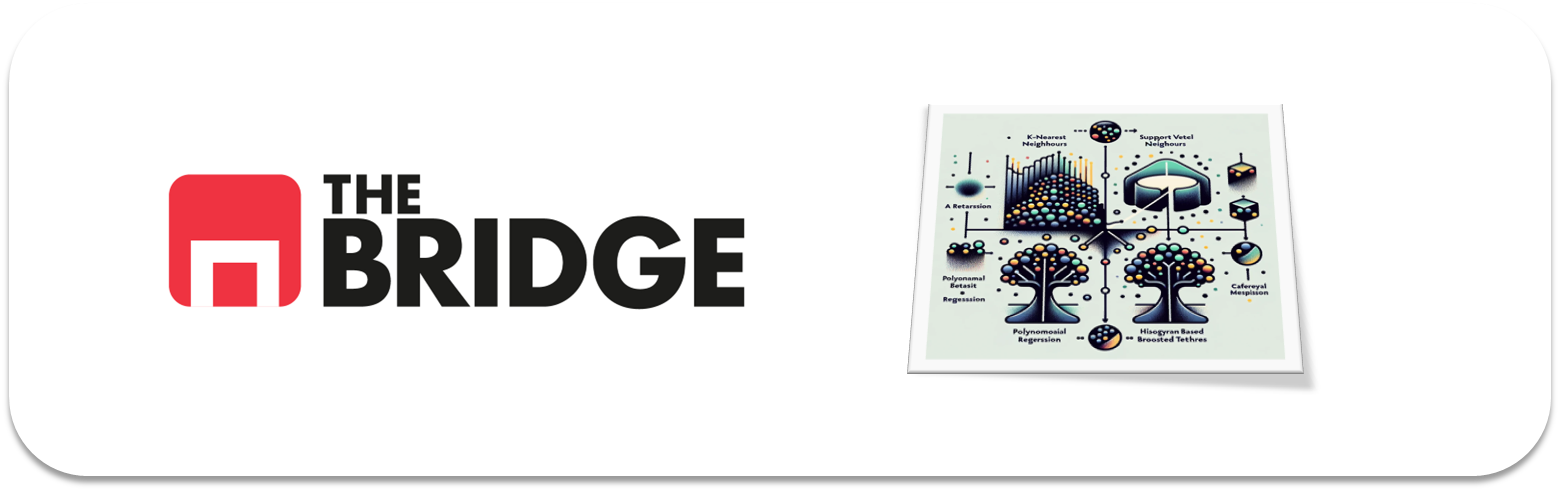

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bootcampviztools as bt
import seaborn as sns
import toolbox_ML as tb
from sklearn.model_selection import train_test_split, cross_val_score

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [3]:
df_credit = pd.read_csv("./data/credit_npo.csv")
df_credit.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


#### Descripción de las variables:
*Para tener una idea más acertada del significado de las variables, se recurre a fuentas como Kaggle y Github donde se encuentra una descripción detallada del dataset y sus columnas.*

- *SeriousDlqin2yrs*: Indica si el cliente supera un plazo de morosidad de 90 días.
- *RevolvingUtilizationOfUnsecuredLines*: Porcentaje del saldo total de creditos personales sin deudas a plazos, dividido por la suma de los limites de crédito.
- *age* : Edad en años.
- *NumberOfTime30-59DaysPastDueNotWorse* : Número de veces que el cliente ha tenido retrasos entre 30 y 59 días, sin empeorar en los últimos dos años.
- *DebtRatio* : Porcentaje de pagos mensuales de deudas, pensión alimenticia y costes de vida divididos por el ingreso bruto mensual.
- *MonthlyIncome*: Ingresos mensuales (no se sabe si es bruto o neto)
- *NumberOfOpenCreditLinesAndLoans* : Numero de préstamos y líneas de credito abiertas. 
- *NumberOfTimes90DaysLate*: Número de veces que el cliente ha tenido más de 90 días de retraso en el pago.
- *NumberRealEstateLoansOrLines*: Número de prestamos hipotecarios y líneas de crédito con garantía hipotecaria.
- *NumberOfTime60-89DaysPastDueNotWorse*: Número de veces que el cliente ha tenido retrasos de entre 60 y 89 días, sin empeorar en los últimos dos años.
- *NumberOfDependents*: Número de personas a cargo.
    


#### Clasificación inicial:

In [4]:
tb.tipifica_variables(df_credit, 8, 5.0) #Ponemos 8 en umbral categorica para que considere todas las columnas como numéricas. 

,nombre_variable,tipo_sugerido
0,SeriousDlqin2yrs,Binaria
1,RevolvingUtilizationOfUnsecuredLines,Numérica Continua
2,age,Numérica Discreta
3,NumberOfTime30-59DaysPastDueNotWorse,Numérica Discreta
4,DebtRatio,Numérica Continua
5,MonthlyIncome,Numérica Continua
6,NumberOfOpenCreditLinesAndLoans,Numérica Discreta
7,NumberOfTimes90DaysLate,Numérica Discreta
8,NumberRealEstateLoansOrLines,Numérica Discreta
9,NumberOfTime60-89DaysPastDueNotWorse,Numérica Discreta


### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

El problema que se quiere tratar es saber si una persona devolverá un préstamos o no, teniendo en cuenta un plazo de morosidad de 90 días. 
La variable target en nuestro caso es **SeriousDlqin2yrs**

### #1.3
Pinta la distribución de frecuencias del target y coméntala

<Axes: xlabel='SeriousDlqin2yrs', ylabel='percent'>

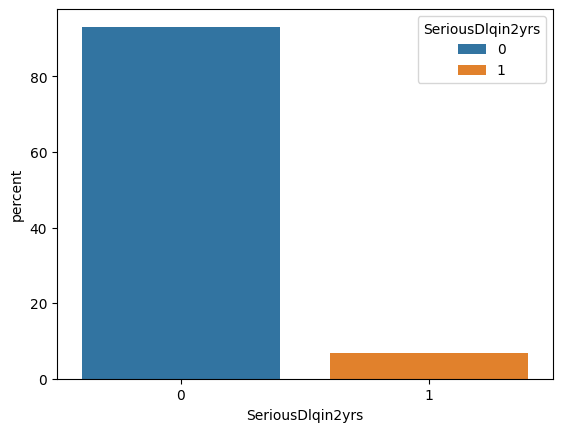

In [5]:
target = 'SeriousDlqin2yrs'
sns.countplot(df_credit, x=target, hue=target, legend=True, stat="percent")

In [6]:
df_credit[target].value_counts(True)

SeriousDlqin2yrs
0    0.931084
1    0.068916
Name: proportion, dtype: float64

Observamos que las clases están muy desbalanceadas. Tendremos que tratarlas de cara al proceso de modelado. 

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

#### Split Train/Test:

In [7]:
train_set, test_set = train_test_split(df_credit, test_size=0.2, stratify=df_credit[target], random_state=42)
print(train_set.shape)
print(test_set.shape)

(10029, 11)
(2508, 11)


#### Mini EDA:

In [8]:
tb.describe_df(train_set)

,COL_N,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,DATA_TYPE,int64,float64,int64,int64,float64,float64,int64,int64,int64,int64,float64
1,MISSINGS (%),0.0,0.0,0.0,0.0,0.0,5.813142,0.0,0.0,0.0,0.0,1.405923
2,UNIQUE_VALUES,2,8628,78,9,9275,3532,41,11,16,8,9
3,CARDIN (%),0.02,86.03,0.78,0.09,92.48,35.21,0.41,0.11,0.16,0.08,0.08


In [9]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10029 entries, 8818 to 10443
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      10029 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  10029 non-null  float64
 2   age                                   10029 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  10029 non-null  int64  
 4   DebtRatio                             10029 non-null  float64
 5   MonthlyIncome                         9446 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans       10029 non-null  int64  
 7   NumberOfTimes90DaysLate               10029 non-null  int64  
 8   NumberRealEstateLoansOrLines          10029 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  10029 non-null  int64  
 10  NumberOfDependents                    9888 non-null   float64
dtypes: float64(4), in

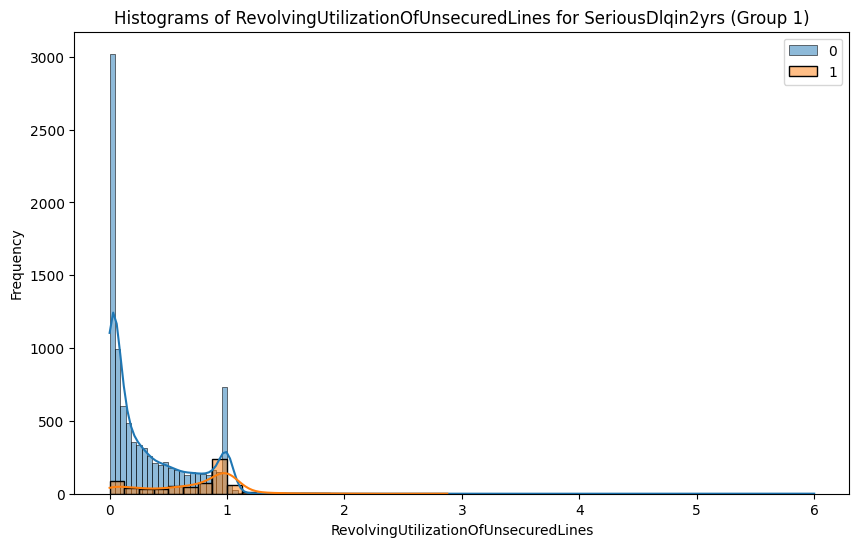

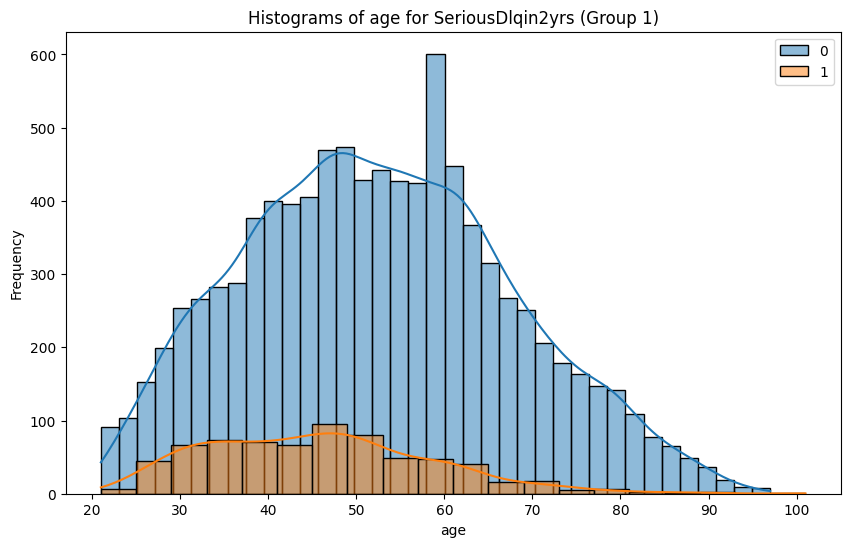

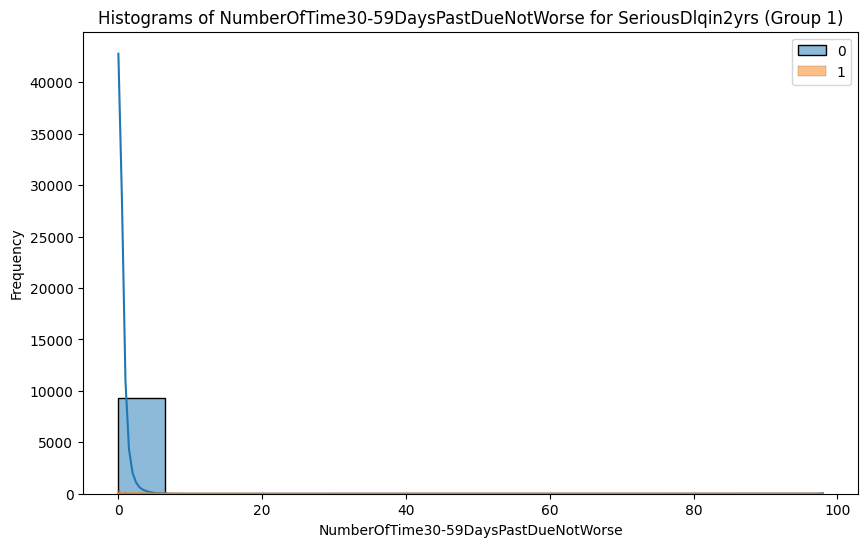

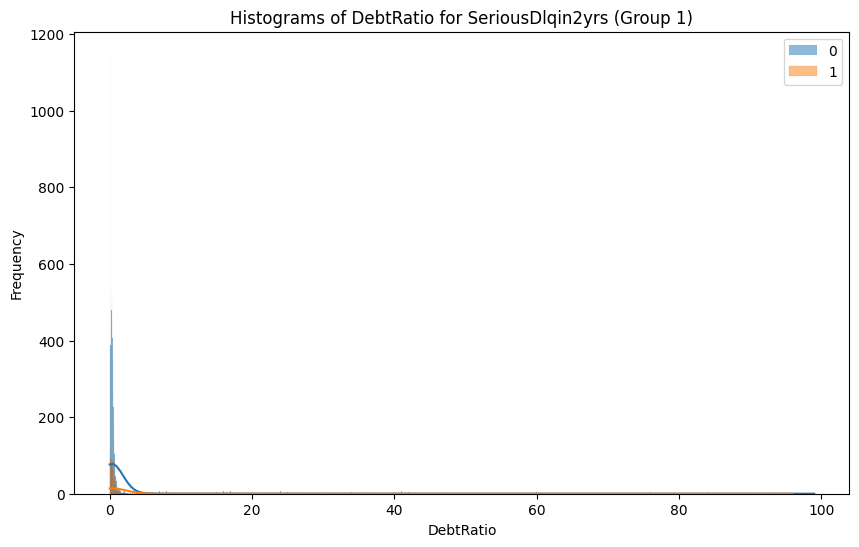

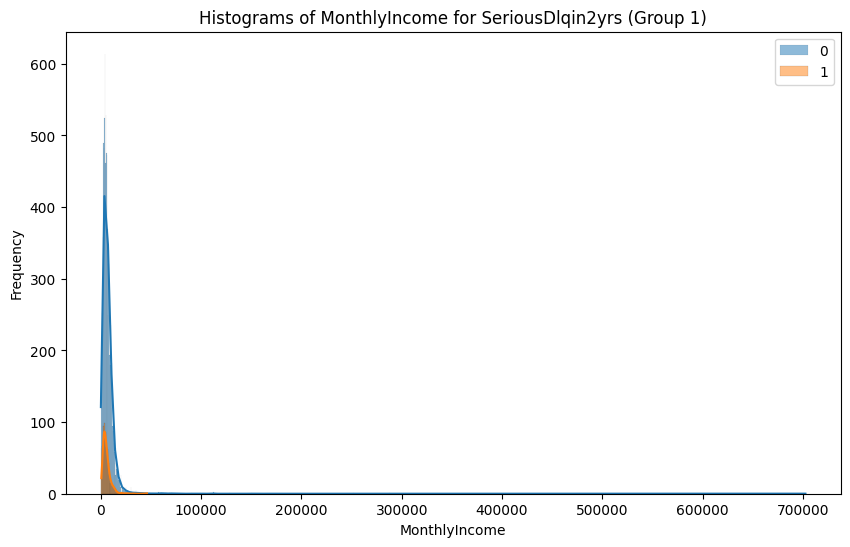

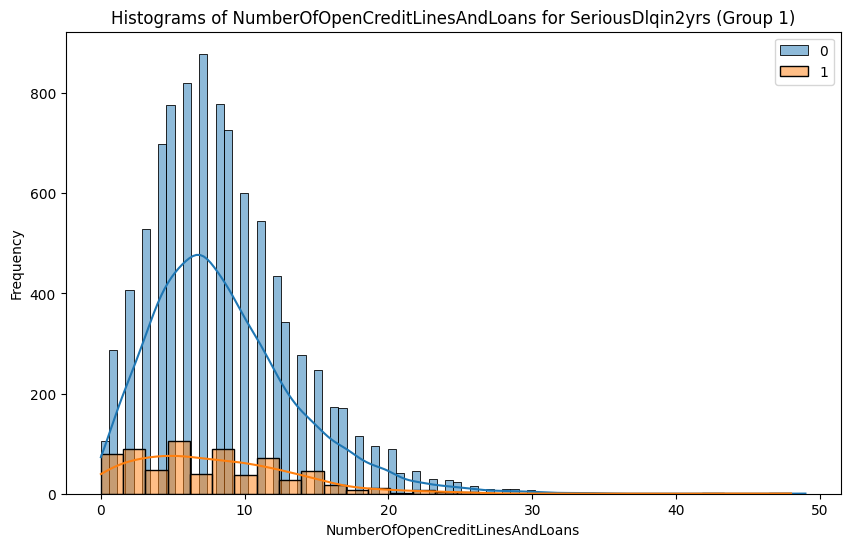

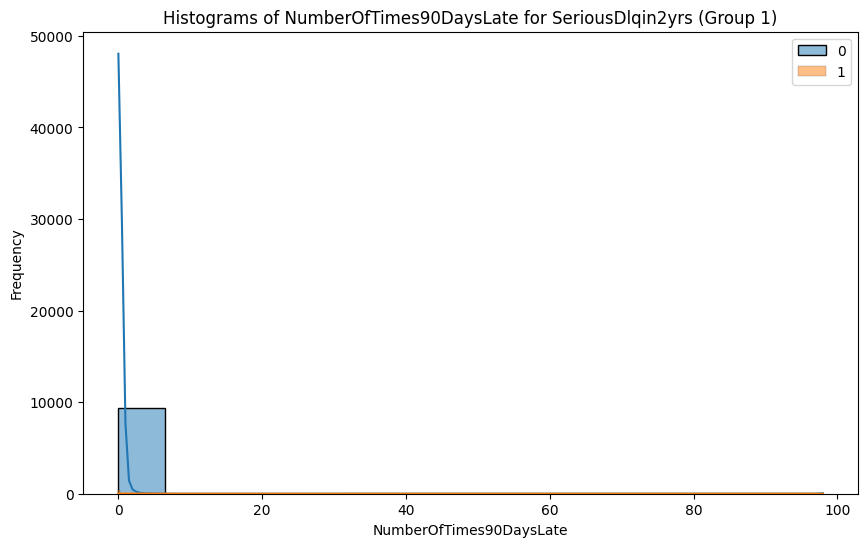

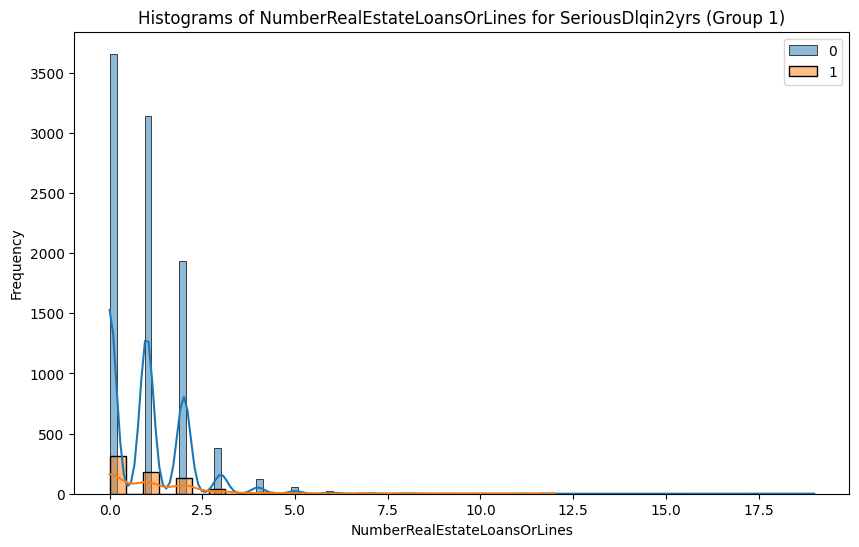

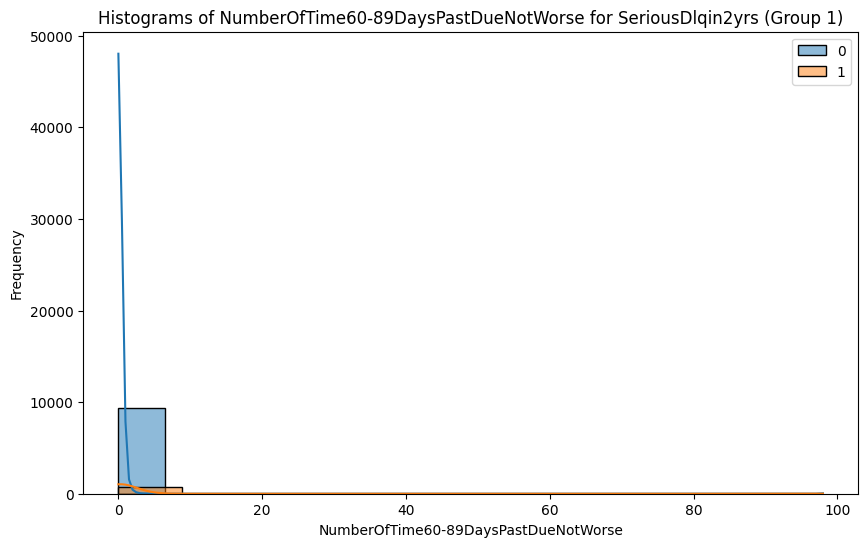

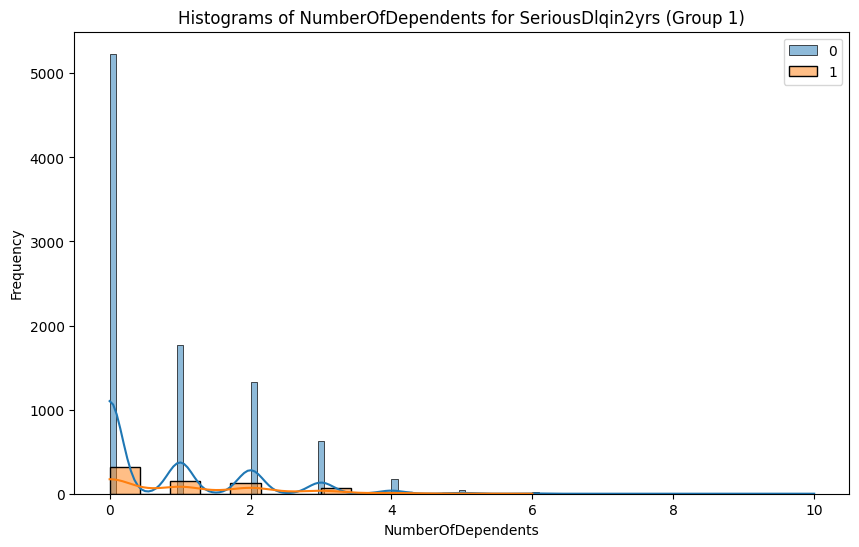

In [10]:
#Antes de tratar los nulos, vamos a ver cómo se realcionan las features con el target. 
features_num = train_set.drop([target], axis=1)

for col in features_num:
    bt.plot_grouped_histograms(train_set, cat_col= target, num_col= col, group_size= 3)

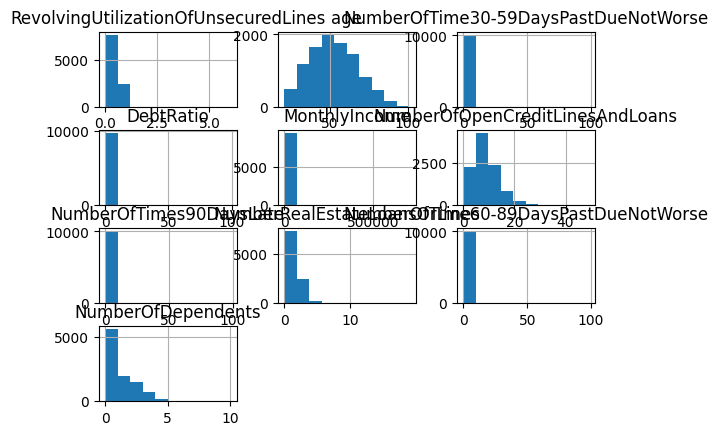

In [11]:
features_num.hist();

*MonthlyIncome y NumberOfDependents son las dos variables que presentan nulos. Después de ver de forma gráfica cómo se comporta con el target, se decide prescindir de MonthlyIncome como feature y para NumberOfDependents, taparemos los nulos con la moda (porqu es numérica discreta y tiene valores enteros), ya que contiene pocos nulos y según su histograma no puede interesar mantenerla.*

In [12]:
train_set["NumberOfDependents"].fillna(train_set["NumberOfDependents"].mode()[0], inplace=True) #Tapamos valores nulos con la moda.
test_set["NumberOfDependents"].fillna(test_set["NumberOfDependents"].mode()[0], inplace=True) # Replicamos en test

# Instanciamos las features con las que nos quedaremos a priori:

features = train_set.columns.to_list()
features.remove(target)
features.remove("MonthlyIncome")
features

C:\Users\bnove\AppData\Local\Temp\ipykernel_6408\2423122927.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_set["NumberOfDependents"].fillna(train_set["NumberOfDependents"].mode()[0], inplace=True) #Tapamos valores nulos con la moda.
C:\Users\bnove\AppData\Local\Temp\ipykernel_6408\2423122927.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the inte

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [13]:
# División X, y:

X_train = train_set[features]
y_train = train_set[target]
X_test = test_set[features]
y_test = test_set[target]

print(X_train.shape)
print(X_test.shape)

(10029, 9)
(2508, 9)


##### Baseline: RandomForestClassifier

In [14]:
# Para el modelo baseline no escalaremos los datos ya que no es necesario en este algorithmo.

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

random_forest_clas = RandomForestClassifier(max_depth = 5, random_state= 42, class_weight='balanced') # balanceamos las clases

print("Recall medio:", np.mean(cross_val_score(random_forest_clas, X_train, y_train, cv = 5, scoring= "balanced_accuracy")))
random_forest_clas.fit(X_train, y_train)


Recall medio: 0.7595217606171395


RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [15]:
# Evaluamos contra train:
print(classification_report(y_train, random_forest_clas.predict(X_train)))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      9338
           1       0.22      0.80      0.34       691

    accuracy                           0.79     10029
   macro avg       0.60      0.79      0.61     10029
weighted avg       0.93      0.79      0.84     10029



*Si nos fijamos en la precisión, vemos que prácticamente va a predecir todos los valores como 0 (negativos) a pesar de que se ha incluido el hiperparámetro class_weight para balancear las clases*

<Axes: >

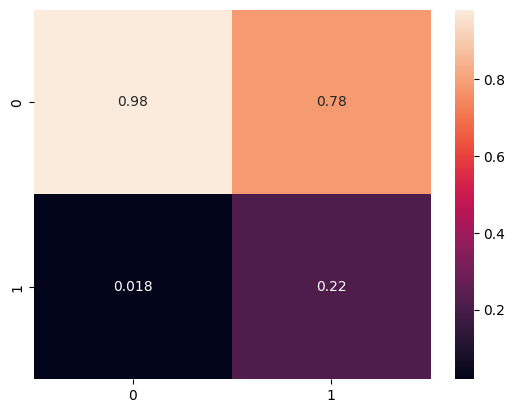

In [101]:
# Vemos la matriz de confusión: 

y_pred = random_forest_clas.predict(X_train)
cm = confusion_matrix(y_train, y_pred, normalize='pred') # 'true') # con pred vemos la precisión 
sns.heatmap(cm, annot=True)

##### KNN, XGBoost y LightGBM
Se selecciona KNN tal y como se pide en el enunciado y además veremos la métrica para XGBoost y LightGBM ante la duda de cuál puede ser el más idóneo.

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

knn = KNeighborsClassifier(n_neighbors= 3) # numero de puntos más cercanos
xgb_clas = XGBClassifier(max_depth = 5, random_state= 42)
lgbm_clas = LGBMClassifier(max_depth= 5, verbose= 0) #verbose a 0 para que no muestre datos de entrenamiento.


Antes de entrenar y ver el recall medio, escalamos las features para KNN y balanceamos el target con SMOTE :

In [113]:
X_train[features].columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [21]:
# Realizamos copia antes de la transformación y el escalado:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()


X_train_scaled.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
8818,0.952783,51,4,0.478968,10,0,3,0,4.0
4520,1.000000,45,0,0.491605,7,0,1,0,0.0
337,0.538922,33,0,0.089734,3,0,0,0,0.0
12501,0.036962,46,0,0.322784,7,0,1,0,0.0
8837,0.089869,42,1,0.091979,3,0,1,0,0.0


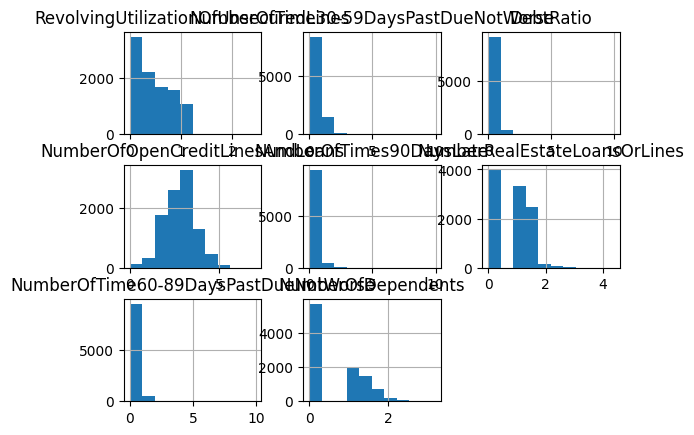

In [20]:
# Aplicamos raiz cuadrada porque hay valores que valen 0 y no podemos aplicar logaritmo. Transformamos todas las variables menos 'age'
sqrt_features = ['RevolvingUtilizationOfUnsecuredLines',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

X_train_scaled[sqrt_features] = np.sqrt(X_train_scaled[sqrt_features])

X_train_scaled[sqrt_features].hist();

#Aplicamos al test:
X_test_scaled[sqrt_features] = np.sqrt(X_test_scaled[sqrt_features])

In [22]:
#Escalamos:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)


In [27]:
# Aplicamos SMOTE para balancear las clases de la variable target al conjunto de sets escalados:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote_scaled, y_train_smote_scaled = smote.fit_resample(X_train_scaled, y_train)
y_train_smote_scaled.value_counts(True) #Comprobamos 

SeriousDlqin2yrs
0    0.5
1    0.5
Name: proportion, dtype: float64

In [28]:
print(X_train_smote_scaled.shape)
print(y_train_smote_scaled.shape)

(18676, 9)
(18676,)


##### Entrenamiento y evaluación de errores:

In [31]:
knn.fit(X_train_smote_scaled, y_train_smote_scaled)

print("Recall medio:", np.mean(cross_val_score(knn, X_train_smote_scaled, y_train_smote_scaled, cv = 5, scoring= "balanced_accuracy")))

Recall medio: 0.9144355244761663


In [32]:
# Para los modelos XGBClassifier y LGBMClassifier aplicamos SMOTE a los sets sin escalar, ya que estos modelos no necesitan escalado:

X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)
y_train_smote.value_counts(True) #Comprobamos 

SeriousDlqin2yrs
0    0.5
1    0.5
Name: proportion, dtype: float64

In [34]:
xgb_clas.fit(X_train_smote, y_train_smote)

print("Recall medio:", np.mean(cross_val_score(xgb_clas, X_train_smote, y_train_smote, cv = 5, scoring= "balanced_accuracy")))

Recall medio: 0.8836504417420107


In [35]:
lgbm_clas.fit(X_train_smote, y_train_smote)

print("Recall medio:", np.mean(cross_val_score(lgbm_clas, X_train_smote, y_train_smote, cv = 5, scoring= "balanced_accuracy")))

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

*Aparentemene el modelo con mejor recall medio es el KNN. Lo evaluamos contra test y mostramos las métricas*

In [36]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.25      0.39      2335
           1       0.07      0.73      0.12       173

    accuracy                           0.28      2508
   macro avg       0.50      0.49      0.26      2508
weighted avg       0.87      0.28      0.37      2508



c:\Users\bnove\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


##### Vamos a probar con el XGBClassifier

In [38]:
y_pred_xgb = xgb_clas.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2335
           1       0.23      0.42      0.30       173

    accuracy                           0.87      2508
   macro avg       0.59      0.66      0.61      2508
weighted avg       0.90      0.87      0.88      2508



In [41]:
# Probamos a optimizar los parámetros con un GridSearch:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100,200,400],
    "eta": [0.1,0.3,0.6,1],
    "max_depth": [1,6,10,None],
    "min_child_weight": [1,10,20,100],
    "colsample_bytree": [0.5,1]
}

xgb_grid = GridSearchCV(xgb_clas,
                       param_grid= param_grid,
                       cv = 5,
                       scoring= "balanced_accuracy")

xgb_grid.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.5, 1],
                         'eta': [0.1, 0.3, 0.6, 1],
                         'max_depth': [1, 6, 10, None],
                         'min_child_weight': [1, 10, 20, 100],
                         'n_estimators': [100, 200, 400]},
             scoring='balanced_accuracy')

In [42]:
xgb_grid.best_params_

{'colsample_bytree': 1,
 'eta': 0.3,
 'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 400}

In [44]:
xgb_grid.best_score_

0.9250927010204281

In [45]:
y_pred_xgb_grid = xgb_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.25      0.39      2335
           1       0.07      0.73      0.12       173

    accuracy                           0.28      2508
   macro avg       0.50      0.49      0.26      2508
weighted avg       0.87      0.28      0.37      2508

